In [1]:
import os
import csv
import SimpleITK as sitk
import six
import featureextractor
from featureextractor import RadiomicsFeatureExtractor
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt 
import pydicom
from pydicom import dcmread
import dicom2nifti
import pydicom_seg
import io
import tempfile
import gc
import time
import shutil
from dicomweb_client.api import DICOMwebClient
import dicom2nifti.settings as settings
import nibabel as nib
import glob

In [2]:
settings. disable_validate_slice_increment()
#pydicom.config.pixel_data_handlers = ['gdcm_handler']

# get the start timen_jobs

st = time.time()
#tmp_dir = os.getenv("SLURM_TMPDIR")                
# Define the float format
float_format = '%.5f'

#path the main directory
main_dir= "/home/ulaval.ca/lesee/projects/Project-NLST/"
main_dir_seg = "/project/166726187/NLST-mask/C1_nii_unzip"

#path of parameter file which includes the settings for radiomics extraction
params = '/project/166726142/lesee/Synergic-Radiomics/src/Params_test.yaml'
auth_token= 'kkaPH62MZeS01bqNeCBDDO'
header = {'Authorization': 'Bearer ' + auth_token}

#giving the path of web-based dicom files
url="https://platform.paradim.science/api"
client_dcm = DICOMwebClient(url = url, headers = header)
all_studies =[]
#data = pd.read_csv(os.path.join(main_dir,'data/Cohort1_labels.csv'))
patient_ids = ["100012"]
for patient_id in patient_ids:
    search_filters = {'PatientID': patient_id}
    studies = client_dcm.search_for_studies(search_filters=search_filters)
    all_studies.extend(studies)
print("Number of Studies with this ID :", len(all_studies))

Number of Studies with this ID : 2


In [3]:
studies_dicom = [pydicom.dataset.Dataset.from_json(d) for d in all_studies]

CT_modality = ['CT']
data_features =[]
index_studies =[]
for num_std , study_dicom in enumerate(studies_dicom): 
    try: 
        #find the series instance ID from SEG file in each study
        study_instance_uid = study_dicom['StudyInstanceUID'].value
        study_date = study_dicom['StudyDate'].value
        patient_ID = study_dicom['PatientID'].value
        patient_name = study_dicom['PatientName'].value  
        print('Study No. = ', num_std+1 )
        print('Patient ID = ', patient_ID )
        print('Study Date = ', study_date )
        metadata_study = client_dcm.retrieve_study_metadata(study_instance_uid = study_instance_uid)
#        modality_values = study_dicom["00080061"]
#        print("Modality Values:", modality_values)
        # check if there is any segmentation file for this study
        if study_date == "19990102":
   
            series = client_dcm.search_for_series(study_instance_uid=study_instance_uid)           
            num_CT = 0
            for no, serie in enumerate(series):
                if no == 1 : 
                    print("Serie No. ", no+1)
                    series_CT_dicom = pydicom.dataset.Dataset.from_json(serie)
                    if series_CT_dicom.Modality in CT_modality:
                        num_CT +=1                    

                        instances_ct = client_dcm.retrieve_series(study_instance_uid = study_instance_uid, 
                                                                  series_instance_uid = series_CT_dicom['SeriesInstanceUID'].value)
                        if len(instances_ct) > 5:      
                            print("Number of Slices =", len(instances_ct))
                            series_instance_uid = series_CT_dicom['SeriesInstanceUID'].value
                            print(series_instance_uid)
                            print(series_CT_dicom.SeriesDescription)
                            #convert the CT dicom images to one nifti file
                            with tempfile.TemporaryDirectory() as tmp_dir:      
                                img_CT = dicom2nifti.convert_dicom.dicom_array_to_nifti(instances_ct,os.path.join(tmp_dir+'_CT.nii'), reorient_nifti=True)["NII"]
                                CT_nifti_path = os.path.join(tmp_dir+'_CT.nii')
                                #read the CT nifit as a sitk image file                 
                                img_CT_stk = sitk.ReadImage(CT_nifti_path)
                                #remove the temporary nifti file after reading
                                os.remove(CT_nifti_path)
                            # Pattern to match the subfolder
                                subfolder_seg_pattern_T0 = os.path.join(main_dir_seg, f'*{patient_ID}*_T0.nii')
                                subfolder_seg_T0 = glob.glob(subfolder_seg_pattern_T0)[0]  # Take the first matching subfolder
                                # Pattern to match the NIfTI file within the subfolder
                                nifti_seg_file_pattern_T0 = os.path.join(subfolder_seg_T0, f'*{patient_ID}*T0.nii')
                                nifti_seg_file_path= glob.glob(nifti_seg_file_pattern_T0)[0]  # Take the first matching file



                                #read the seg nifit as a sitk image file
                            img_mask = sitk.ReadImage(nifti_seg_file_path)                                

        else: 
#            studies_no_seg.append(patient_name)
    
            print ("No mask for Patient ID " + str(patient_ID)+" with Study Date "+ str (study_date))
            continue
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        #print(features_key)        

Study No. =  1
Patient ID =  100012
Study Date =  20000102
No mask for Patient ID 100012 with Study Date 20000102
Study No. =  2
Patient ID =  100012
Study Date =  19990102
Serie No.  2
Number of Slices = 162
1.2.840.113654.2.55.335938848402215862539398120263494500079
0,OPA,SE,VZOOM,B30f,300,2,120,75,40,na


In [4]:
# Extract the CT and mask images that pyradiomics uses for extraction of features from changed featureextractor.py in the current path
extractor = featureextractor.RadiomicsFeatureExtractor(params, additionalInfo=True)
extractor.settings['n_jobs'] = -1
#extract the resamples CT and mask images by giving the flipped CT and original mask to the function
inputImage_rads, inputMask_rads = extractor.execute(img_CT_stk, img_mask, label = 1)

In [5]:
#function to visualize overlaying mask on CT slices after resampling (the same number of slices between CT and mask)
def visualize_slices_with_segmentation_equal_slices(ct_volume, seg_volume):
    # Convert SimpleITK images to NumPy arrays
    ct_array = sitk.GetArrayFromImage(ct_volume)
    seg_array = sitk.GetArrayFromImage(seg_volume)

    # Number of slices
    num_slices = ct_array.shape[0]

    for slice_idx in range(num_slices):
        # Extract the corresponding slices
        ct_slice = ct_array[slice_idx, :, :]
        seg_slice = seg_array[slice_idx, :, :]

        # Visualize the overlay
        plt.figure(figsize=(8, 8))
        plt.imshow(ct_slice, cmap='gray')
        plt.imshow(seg_slice, alpha=0.2, cmap='jet')  # Adjust alpha for transparency
        plt.title(f"Slice {slice_idx + 1}")
        plt.axis('off')
        plt.show()


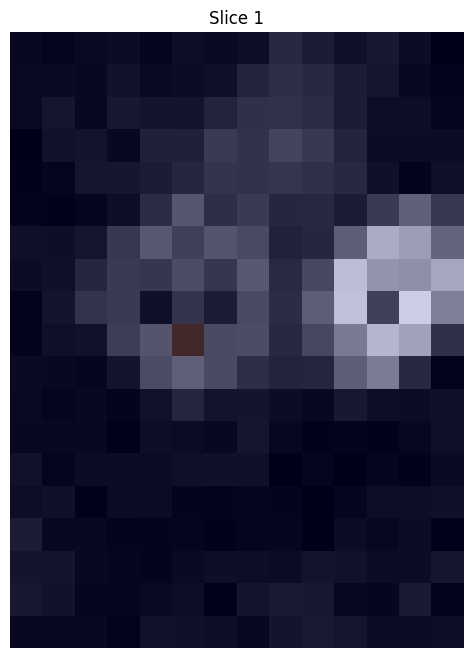

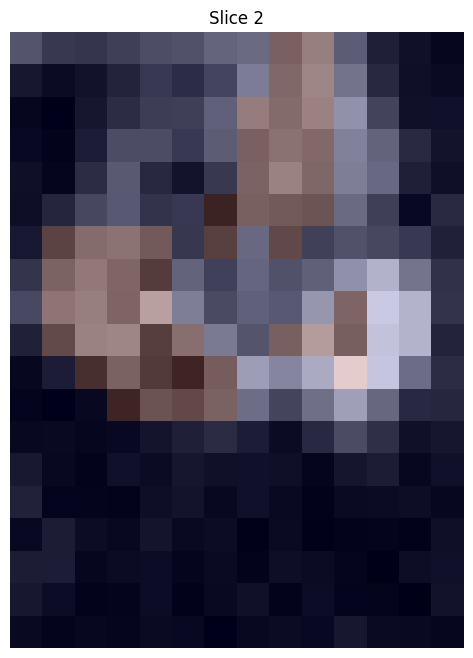

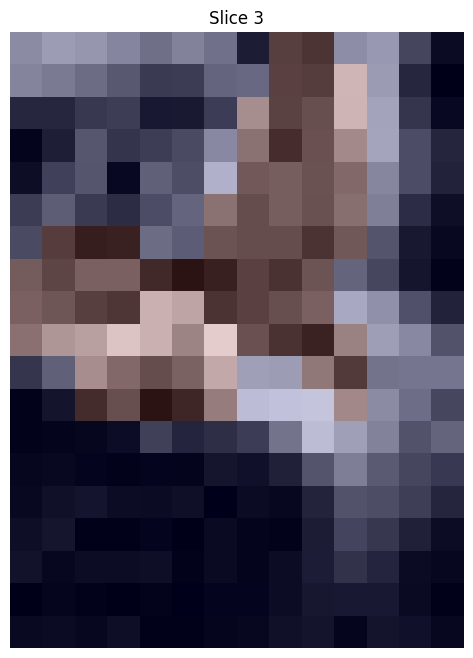

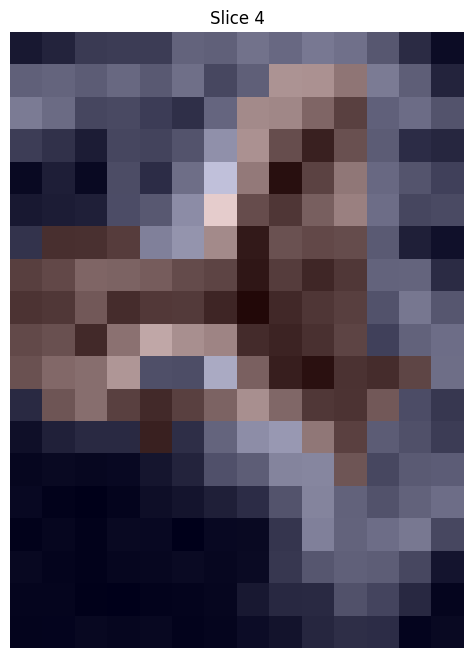

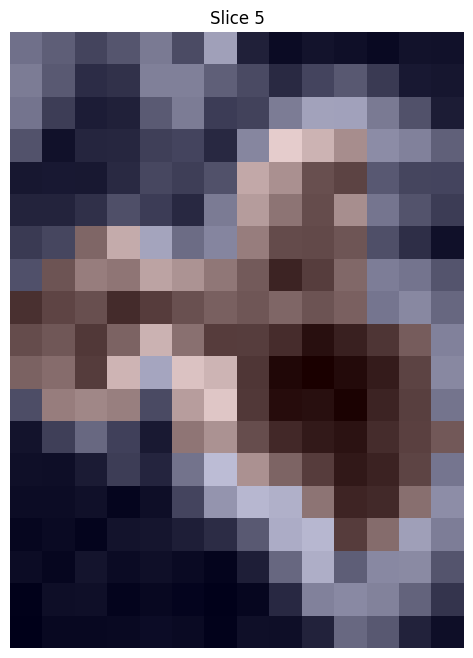

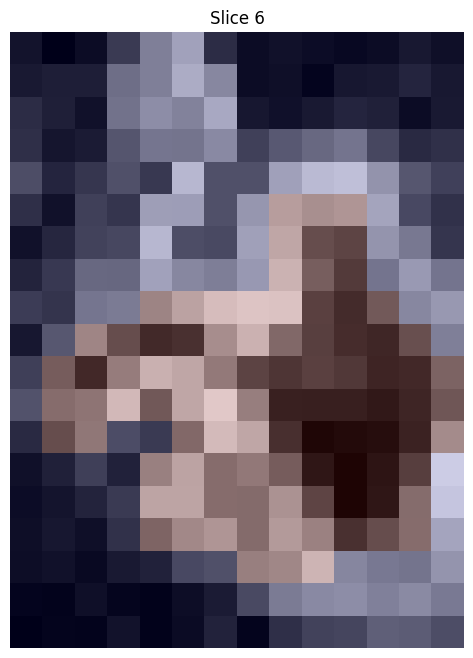

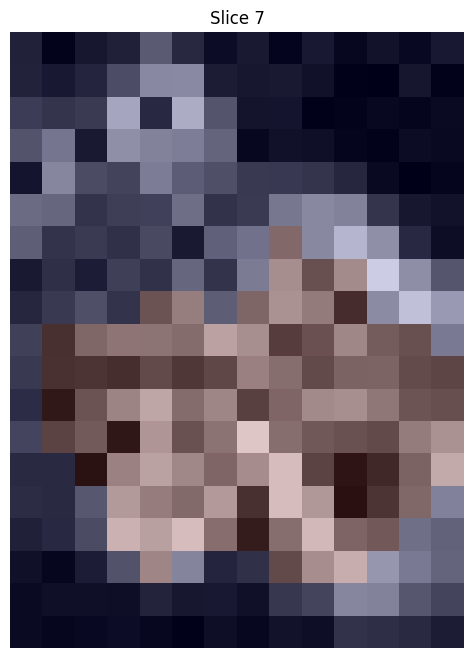

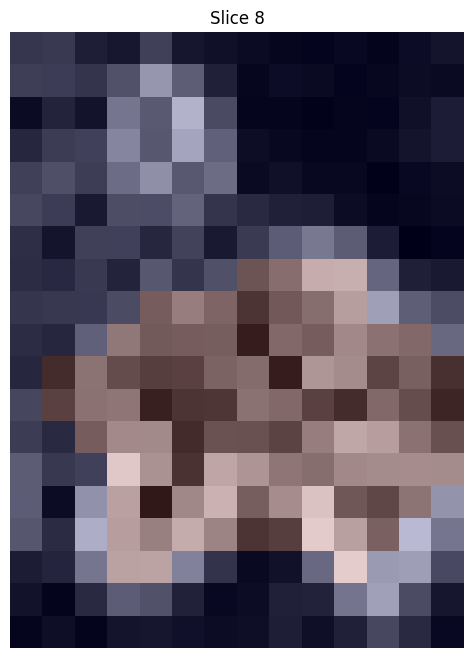

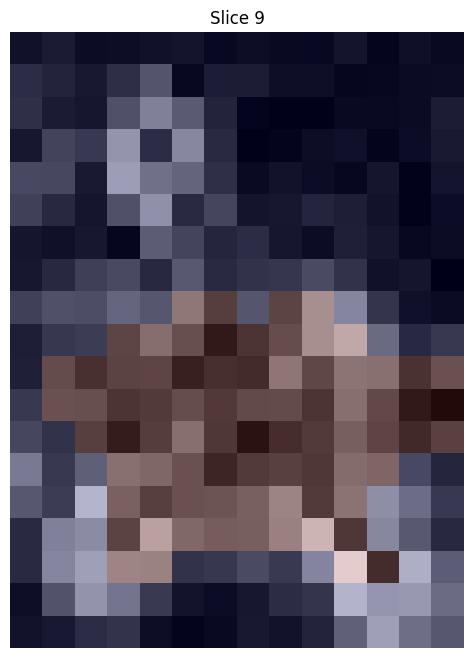

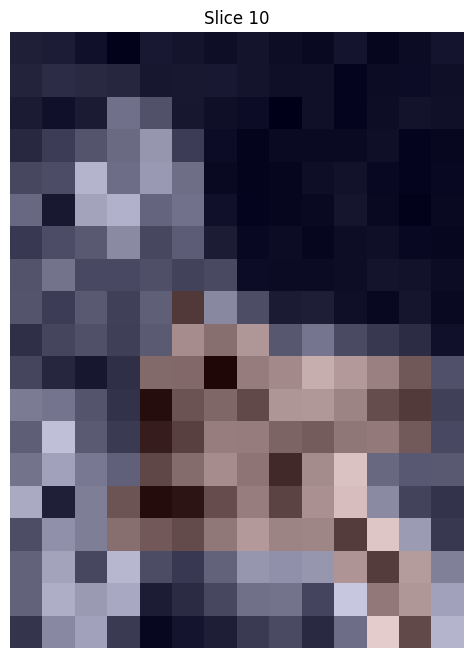

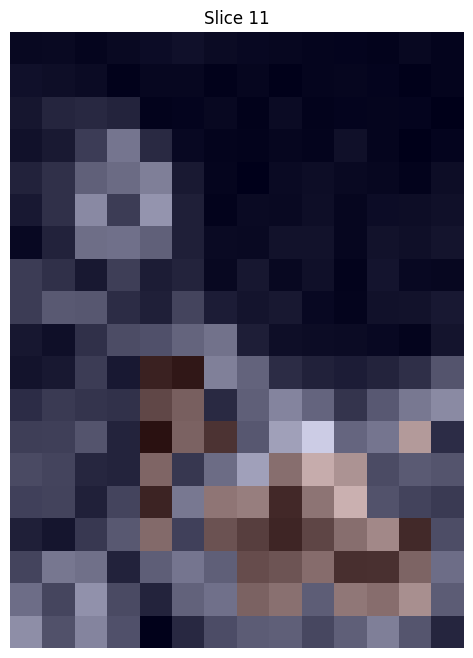

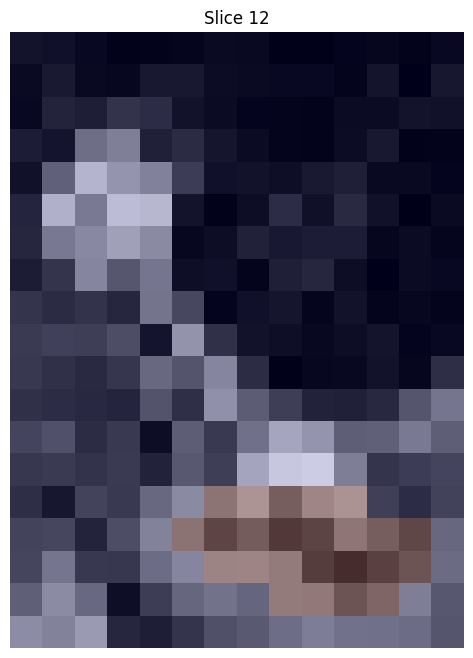

In [6]:
# Visualize slices with segmentation overlay from which radiomics is extracted
visualize_slices_with_segmentation_equal_slices(inputImage_rads, inputMask_rads)

In [7]:
def find_slices_with_segmentation(seg_volume):
    # Find the indices of slices where all values are non-zero
    seg_array = sitk.GetArrayFromImage(seg_volume)
    slice_indices = np.any(seg_array != 0, axis=(1, 2))
    return np.where(slice_indices)[0]

mask_volume = img_mask
slice_indices_with_seg = find_slices_with_segmentation(mask_volume)
print(slice_indices_with_seg)

[120 121 122 123 124 125 126 127 128 129 130 131]


In [10]:
# Function to visualize slices with segmentation
def visualize_slices_with_segmentation(ct_volume, seg_volume, flip_seg):
    # Convert SimpleITK images to NumPy arrays
    ct_array = sitk.GetArrayFromImage(ct_volume)
    seg_array = sitk.GetArrayFromImage(seg_volume)
    print(len(seg_array))
    print(len(ct_array))    

#    slice_indices = [121, 126, 131]  # Replace with the desired slice indices
    slice_indices = slice_indices_with_seg  # Replace with the desired slice indices    
    num_slices = len(slice_indices)

    for i, idx in enumerate(slice_indices):
        ct_slice = ct_array[idx, :, :]
        seg_slice = seg_array[idx, :, :]

        

        # Visualize the overlay
        plt.figure(figsize=(8, 8))
        plt.imshow(ct_slice, cmap='gray')
        # Apply flipping to segmentation slice if needed
        seg_slice = np.flip(seg_slice, axis=0) if flip_seg else seg_slice        
        plt.imshow(seg_slice, alpha=0.2, cmap='jet')  # Adjust alpha for transparency
        plt.title(f"Slice {idx + 1}")
        plt.axis('off')
        plt.show()



162
162


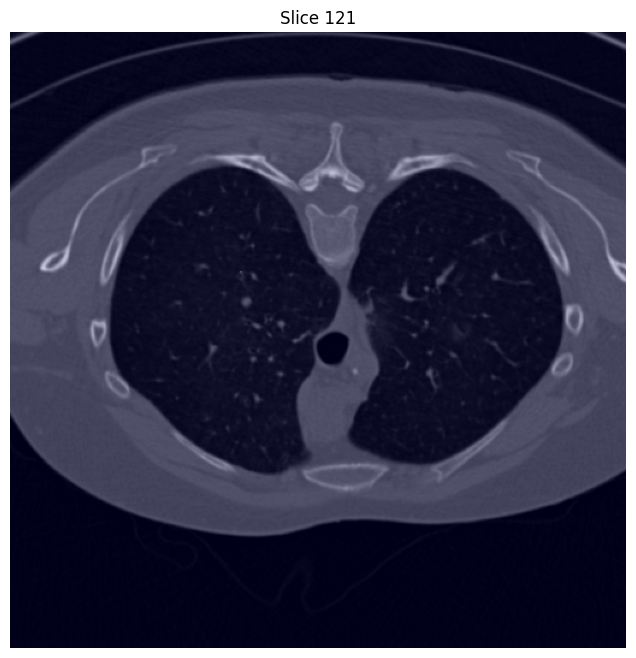

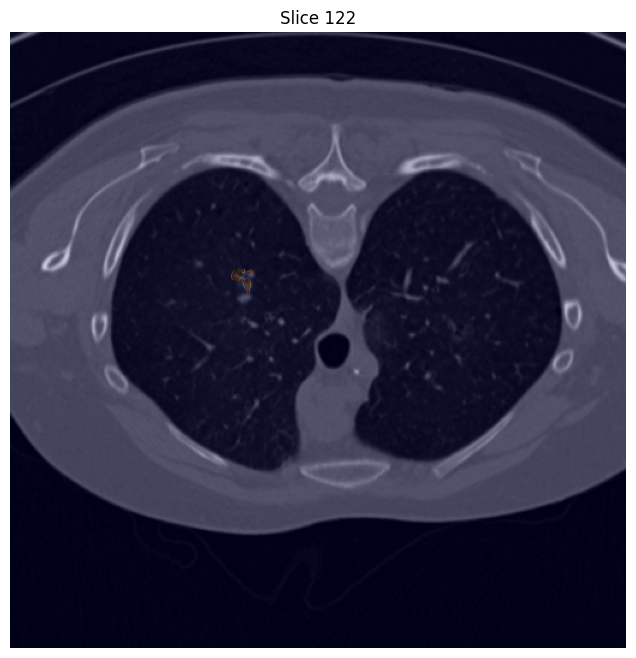

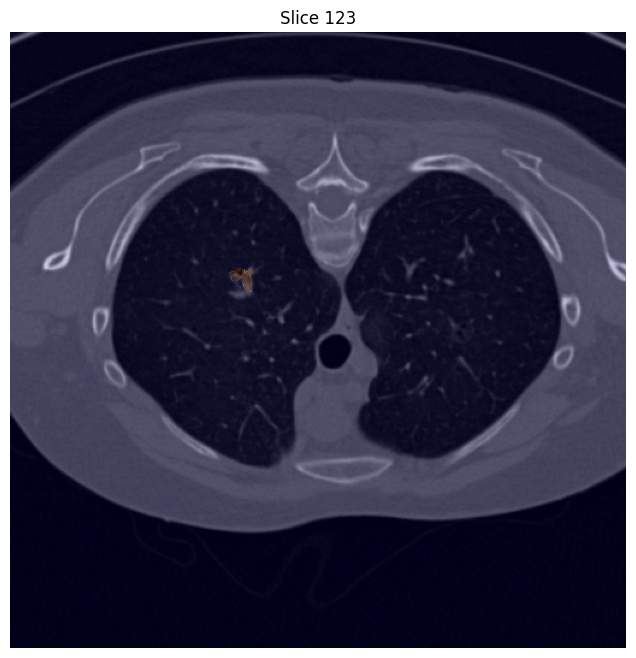

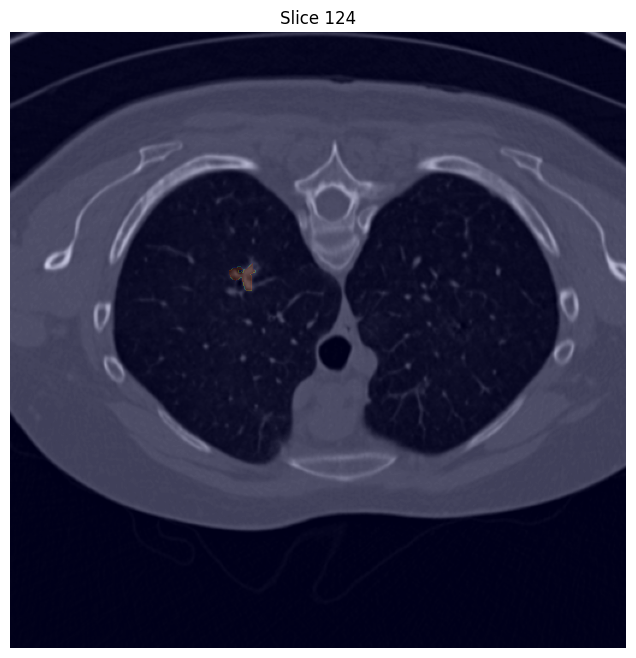

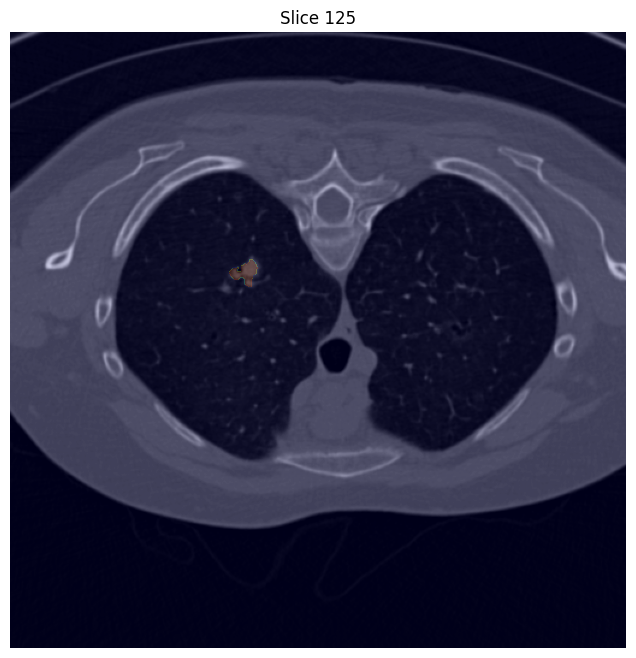

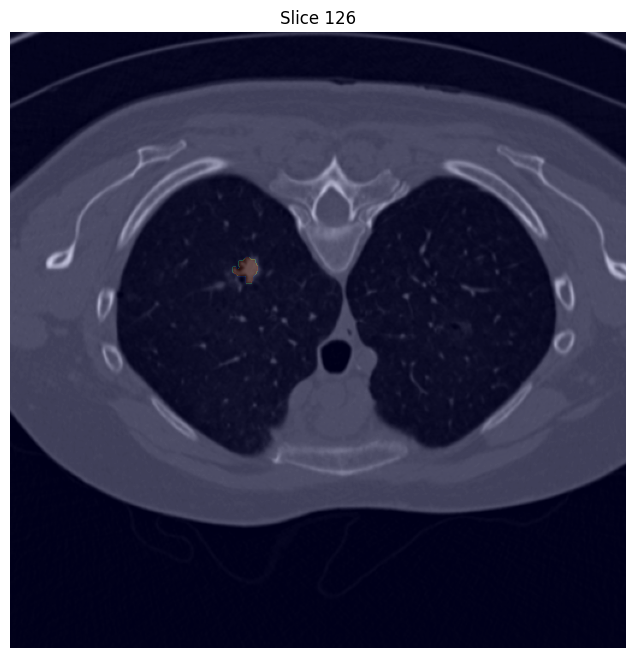

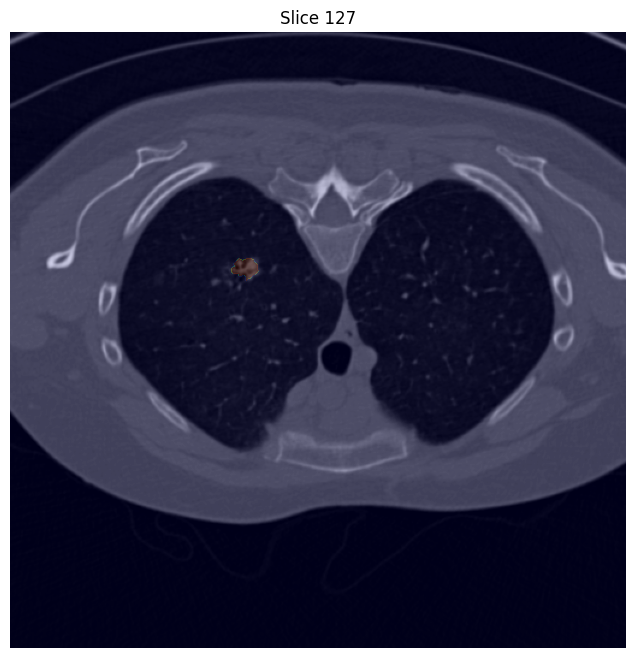

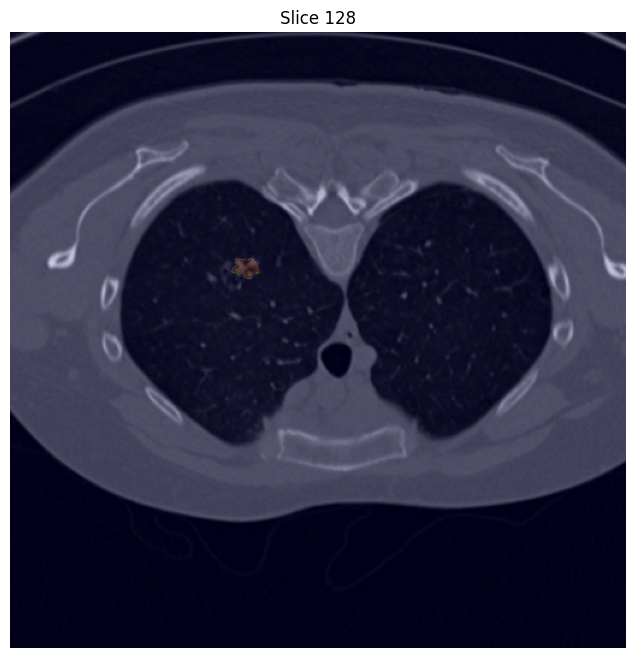

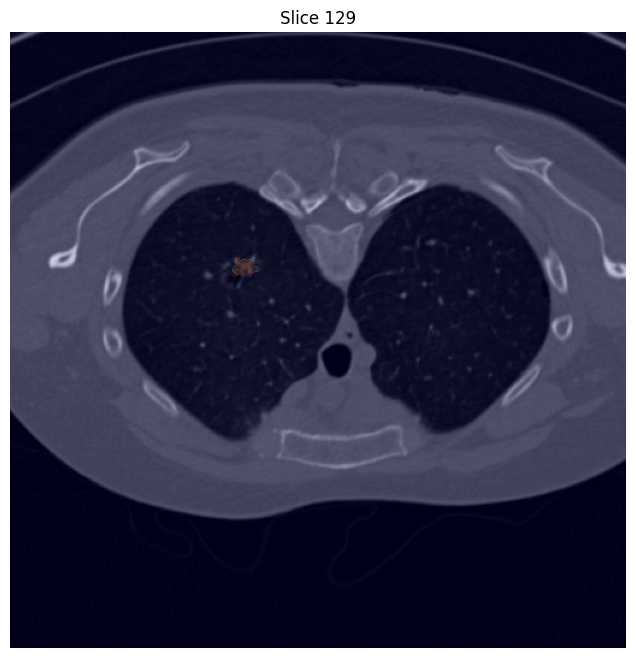

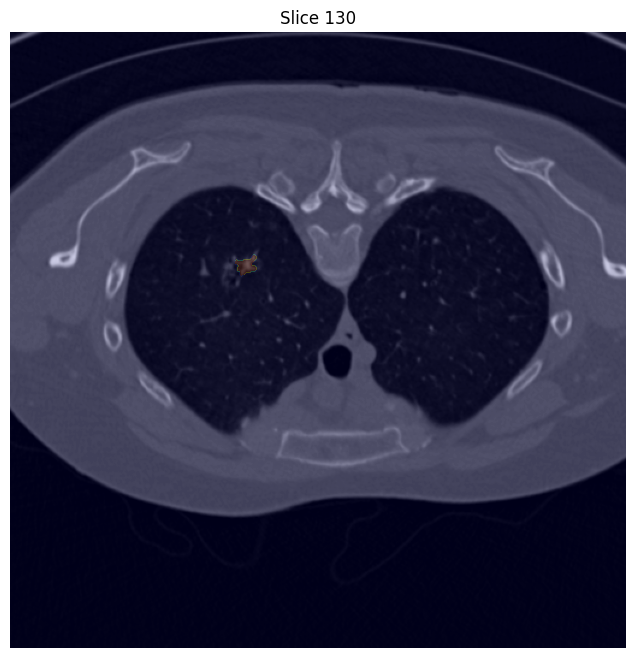

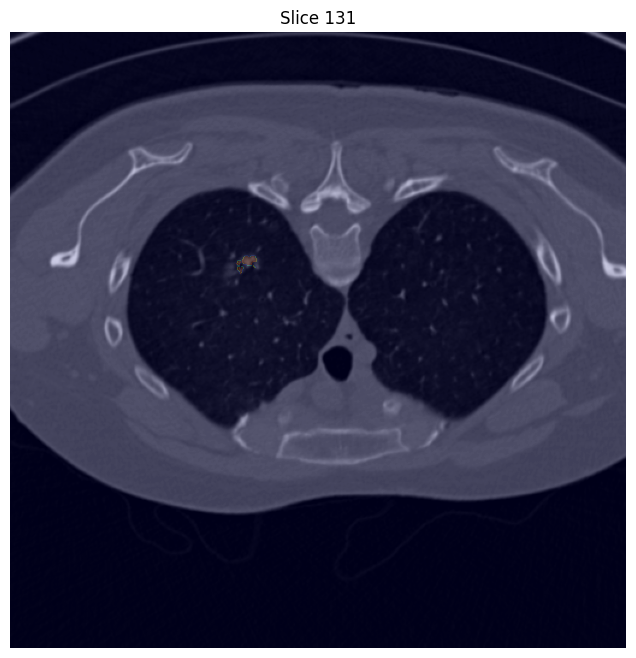

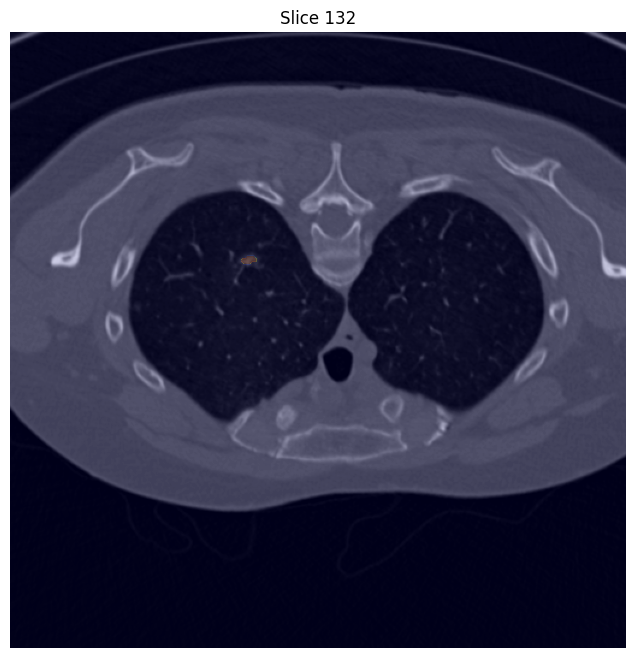

In [12]:
# Load CT and segmentation volumes
#img_mask_flipped = sitk.Flip(img_mask, [False, True, False])
ct_volume = img_CT_stk

# Visualize slices with segmentation overlay
visualize_slices_with_segmentation(ct_volume, img_mask, flip_seg=True)
#visualize_slices_with_segmentation(ct_volume, img_mask_flipped, flip_seg=False)